# Latent Semantic Analysis (LSA)

**LSA** es una técnica de reducción de la dimensionalidad que nos permite asociar en forma más notoria distintos objetos de un problema. En nuestro caso, reducir la dimensión del espacio de términos en el cual están descritos los documentos nos permitirá ver más fácilmente qué documentos son más parecidos entre sí. Asimismo, reducir el espacio de documentos en el que están descritos los términos nos permitirá ver el grado de asociación entre los mismos. Prácticamente cualquier técnica de reducción de la dimensionalidad nos permite abstraernos de las particularidades de los objetos de estudio y concentrarnos en sus elementos en común.

Utilizemos el diccionario creado y el corpus de prueba para ver cómo implementar **Latent Semantic Analysis**. Si bien **Gensim** tiene una implementación, vamos a utilizar la de **Scikit-learn** que nos permite a acceder a más información numérica.

Algunos headers primero:

In [1]:
# -*- coding: utf8 -*-
%matplotlib inline

# La primer línea es para poder escribir comentarios con tilde y caracteres de español.
# La segunda necesaria para que se muestren todos los gráficos en la notebook.

Comenzamos cargando el diccionario y el corpus previamente construidos:

In [2]:
from gensim.corpora import Dictionary
import cPickle as pk

# Cargado del diccionario construido
dictionary = Dictionary.load('tutorial.dict')

# Cargado del corpus como bag or words
corpus = pk.load(file('Tutorial_corpus.pk','r'))

Para utilizar la implementación en **Scikit-learn** necesitamos transformar el corpus en una matriz *sparse* que **Scikit-learn** entiende. **Gensim** nos permite hacer esto fácilmente:

In [3]:
from gensim.matutils import corpus2csc

# Conversión del corpus creado por Gensim a una matriz de scikit-learn
corpus2sklearn = corpus2csc(corpus).T

La trasposición (*.T*) nos permite que la matriz quede armada de forma tal que cada documento sea un vector fila en el espacio de términos (más adelante analizaremos la matriz términos por documentos). Esto se ve inspeccionando las dimensiones de la matriz:

In [4]:
print('Dimensiones: {}'.format(corpus2sklearn.shape))

Dimensiones: (400, 18646)


Vemos entonces que la matriz tiene 400 filas que es el número de documentos cargados y 18646 términos que los describen.

Dado que los documentos son vectores descritos en el espacio de términos podemos preguntarnos qué tan similares son entre ellos. Una medida de utilidad es el coseno del ángulo comprendido entre dos vectores documento, siendo 0 cuando los vectores son ortogonales y 1 cuando apuntan en la misma dirección. El módulo *scipy.spatial.distance* tiene muchas funciones distancia incorporadas que podemos aprovechar para este cálculo, entre ellas la distancia coseno (aunque formalmente no sea una distancia métrica):

In [5]:
from scipy.spatial.distance import cosine

# Similitud a partir de la "distancia" coseno:
# 1 - cosine() da el coseno del ángulo entre los vectores argumento

# Debemos llamar al vector del documento i como corpus2sklearn[i].toarray()[0] 
# dado que tenemos que extraerlo de una matriz comprimida, pero usualmente basta con matrix[i]

# Similitud entre el documento 0 y el documento 1
aux = 1.00 - cosine(corpus2sklearn[0].toarray()[0], corpus2sklearn[1].toarray()[0])
print(u'Documentos 0 y 1: similitud = {}'.format(aux))

# Similitud entre el documento 0 y el documento 200
aux = 1.00 - cosine(corpus2sklearn[0].toarray()[0], corpus2sklearn[200].toarray()[0])
print(u'Documentos 0 y 200: similitud = {}'.format(aux))

Documentos 0 y 1: similitud = 0.0900233126263
Documentos 0 y 200: similitud = 0.00966285059421


El corpus fue preparado especialmente con 400 documentos que pertenecen a 4 tópicos, ordenados de 100 en 100. Vemos entonces que la similitud entre el documento 0 y 1 es mayor que entre el documento 0 y 200, que pertencen a distintos tópicos. Sin embargo la similitud en ambos casos parece muy baja. **Veamos cómo mejora esta situación al reducir la dimensionalidad del problema con LSA**.

### LSA = Singular Value Decomposition (SVD)

Realizar LSA es los mismo que buscar la descomposición en [valores singulares](https://es.wikipedia.org/wiki/Descomposici%C3%B3n_en_valores_singulares) de una matriz rectangular . Dada la matriz $A$ que en nuestro caso será la matriz de *m* documentos por *n* términos (donde recordemos cada entrada es la frecuencia con la que aparece un dado término en el documento), la descomposición en valores singulares descompone la matriz como:

$$ A^{(m \times n)} = U^{(m \times m)} \cdot S^{(m \times n)} \cdot (V^{(n \times n)})^T $$

La matriz $S$ es una matriz rectangular con los valores singulares en la diagonal del bloque con la dimensión inferior (completando con ceros el resto de las columnas). La reducción de la dimensionalidad se produce cuando se descartan los valores singulares más chicos y se recompone la matriz $A$.
Vamos a utilizar **Scikit-learn** para la aplicación de este modelo. 
El esquema de trabajo en **Scikit-learn** es generalmente el siguiente:
- Importar la clase del modelo que queremos utilizar.
- Creamos un objeto a partir de la clase con los parámetros que querramos.
- Llamamos al método *fit_transform* del objeto creado pasandole como argumentos los datos, en nuestro caso la matriz asociada al corpus.

Por lo tanto comenzamos importando la clase de SVD:

In [6]:
from sklearn.decomposition import TruncatedSVD

Lo siguiente es crear un objeto a partir de la clase importada. Ya que **SVD** se utiliza para reducir la dimensionalidad del problema, hay que especificar como argumento cuántas dimensiones vamos a conservar. Como en principio no sabemos nada de los datos utilizamos la dimensión más chica (-1 por cómo es la implementación del algoritmo) de la matriz del corpus de forma tal de realizar la transformación sin pérdida de información al principio (en este caso la transformación correspondería simplemente a un cambio de base):

In [7]:
# Objeto svd a partir de la clase TruncatedSVD
svd = TruncatedSVD(n_components = min(corpus2sklearn.shape)-1)

Transformamos la matriz del corpus a la nueva base, donde cada vector base es una combinación lineal de los términos del espacio original:

In [8]:
corpus_transformed = svd.fit_transform(corpus2sklearn)

Vemos que las dimensiones de la matriz corpus transformada es ahora el número de documentos por el número de las nuevas dimensiones:

In [9]:
print('Dimensiones: {}'.format(corpus_transformed.shape))

Dimensiones: (400, 399)


#### ¿Cuánta información hay contenida en cada dimensión? 
Por defecto, **SVD** ordena las dimensiones por cantidad de información contenida, es decir la primer dimensión tiene más información que la segunda, la segunda más que la tercera, etc. Podemos acceder a la fracción de varianza explicada en cada dimensión mediante el siguiente método del objeto **svd**:

In [10]:
# Vemos la fracción de los primeras 20 dimensiones
print(svd.explained_variance_ratio_[:20])

[0.06024648 0.07750942 0.03829153 0.0360149  0.02902977 0.02499114
 0.02120786 0.01580438 0.01478186 0.0126623  0.01251634 0.01219027
 0.01084258 0.0087837  0.0086163  0.00778815 0.00753736 0.00740165
 0.00721298 0.00714912]


Finalmente veamos gráficamente el acumulado de información a medida que aumentamos el número de dimensiones:

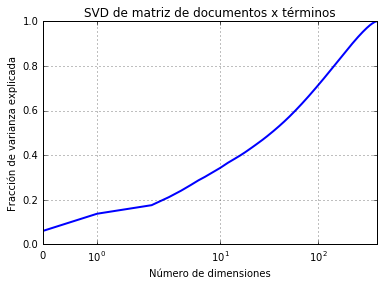

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Gráfico de información acumulada
plt.figure(1)
plt.plot(np.cumsum(svd.explained_variance_ratio_), linewidth = 2)
plt.xscale('symlog')
plt.xlim([0, 400])
plt.xlabel(u'Número de dimensiones')
plt.ylabel(u'Fracción de varianza explicada')
plt.title(u'SVD de matriz de documentos x términos')
plt.ylim([0.00, 1.00])
plt.grid('on')
plt.show()


Del último gráfico podemos observar por ejemplo que 10 dimensiones son suficientes para explicar alrededor del 35% de la información y con 100 dimensiones alrededor del 70%. Nos quedamos con 20 dimensiones con las que se explica alrededor del 40%. Para recudir nuestra matriz a este número de dimensiones debemos construir nuevamente el objeto **svd**:

In [12]:
# Objeto svd con 20 dimensiones
svd = TruncatedSVD(20)

# Transformamos la matriz del corpus
corpus_transformed = svd.fit_transform(corpus2sklearn)

# Vemos la dimensión de la matriz transformada
print('Dimensiones: {}'.format(corpus_transformed.shape))

Dimensiones: (400, 20)


Volvamos a ver entonces cómo es la similitud entre los documentos en el espacio reducido:

In [13]:
# Similitud entre el documento 0 y el documento 1
aux = 1.00 - cosine(corpus_transformed[0], corpus_transformed[1])
print(u'Documentos 0 y 1: similitud = {}'.format(aux))

# Similitud entre el documento 0 y el documento 200
aux = 1.00 - cosine(corpus_transformed[0], corpus_transformed[200])
print(u'Documentos 0 y 200: similitud = {}'.format(aux))

Documentos 0 y 1: similitud = 0.651546840531
Documentos 0 y 200: similitud = 0.0362292286069


Notamos que las similitud entre el documento 0 y el documento 1 aumentó en forma drástica mientras que entre el documento 0 y el documento 200 se mantuvo en valores bajos. La reducción de la dimensionalidad acerca los documentos que esperabamos sean similares y mantiene distanciados aquellos documentos pertenecientes a distintas temáticas.

### Descripción del problema en el espacio de términos

La aplicación de LSA suele hacerse [no sobre la matriz de documentos por términos sino sobre la matriz traspuesta](http://web.cs.ucla.edu/~rosen/161/hw/intro_to_LSA.pdf). Con esto podemos analizar por ejemplo la similitud entre términos. 
Realicemos esto repitiendo prácticamente el mismo análisis que antes pero partiendo de la matriz dada por *Gensim* sin hacer la trasposición inicial:

In [21]:
# Utilizamos la matriz tal como la entrego gensim
corpus2sklearn = corpus2csc(corpus)

print('Dimensiones: {}'.format(corpus2sklearn.shape))

Dimensiones: (18646, 400)


Vemos que nuestra matriz de interés tiene como vectores filas todos los términos utlizados para la descripción del corpus. ¿Cómo es la relación entre las filas y los términos? Se lo preguntamos al diccionario. Si queremos averiguar en qué fila se ubica un término específico llamamos al método token2id:

In [15]:
print('aborto - fila: {}'.format(dictionary.token2id[u'aborto']))
print(u'despenalización - fila: {}'.format(dictionary.token2id[u'despenalización']))
print(u'trump - fila {}'.format(dictionary.token2id[u'trump']))

aborto - fila: 0
despenalización - fila: 1267
trump - fila 435


Veamos la similitud entre términos analogamente a lo que hicimos con los documentos, antes de aplicar la reducción de la dimensionalidad:

In [16]:
# Similitud entre términos 
aux = 1.00 - cosine(corpus2sklearn[0].toarray()[0], corpus2sklearn[1267].toarray()[0])
print(u'aborto y despenalización: similitud = {}'.format(aux))

aux = 1.00 - cosine(corpus2sklearn[0].toarray()[0], corpus2sklearn[435].toarray()[0])
print(u'aborto y trump: similitud = {}'.format(aux))

aborto y despenalización: similitud = 0.538457149861
aborto y trump: similitud = 0.00594193008084


En este caso más que similitud nos indica que los términos que comparamos aparecen en un contexto similar.

Apliquemos ahora **SVD** para ver cuál es el efecto de reducir la dimensionalidad del problema. Inspeccionamos primero la cantidad de información contenida en cada dimensión realizando una transformación prácticamente sin pérdida de información:

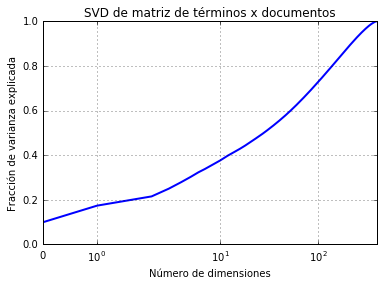

In [17]:
# Objeto svd a partir de la clase TruncatedSVD
svd = TruncatedSVD(n_components=min(corpus2sklearn.shape)-1)

# Transformación del corpus de términos x documentos
corpus_transformed_terms = svd.fit_transform(corpus2sklearn)

# Gráfico de información acumulada
plt.figure(2)
plt.plot(np.cumsum(svd.explained_variance_ratio_), linewidth = 2)
plt.xscale('symlog')
plt.xlim([0, 400])
plt.xlabel(u'Número de dimensiones')
plt.ylabel(u'Fracción de varianza explicada')
plt.title(u'SVD de matriz de términos x documentos')
plt.ylim([0.00, 1.00])
plt.grid('on')
plt.show()


Reteniendo solo 20 dimensiones, al igual que antes, se explica alrededor del 40% de la varianza. Aplicamos entonces **SVD** con este número de dimensiones, obteniendo una descripción de los términos descriptos en un espacio reducido, cuya vectores base son ahora combinaciones lineales de los documentos:

In [18]:
# Objeto svd con 20 dimensiones
svd = TruncatedSVD(20)

# Transformación del corpus de términos por documentos
corpus_transformed_terms = svd.fit_transform(corpus2sklearn)

Inspeccionamos la dimensiones de la matriz transformada:

In [19]:
print('Dimensiones: {}'.format(corpus_transformed_terms.shape))

Dimensiones: (18646, 20)


Finalmente, vemos cuál fue el efecto de la reducción de la dimensionalidad en la similitud entre términos:

In [20]:
aux = 1.00 - cosine(corpus_transformed_terms[0], corpus_transformed_terms[1267])
print(u'aborto y despenalización: similitud = {}'.format(aux))

aux = 1.00 - cosine(corpus_transformed_terms[0], corpus_transformed_terms[435])
print(u'aborto y trump: similitud = {}'.format(aux))

aborto y despenalización: similitud = 0.794570943312
aborto y trump: similitud = 0.00569115593022


Vemos que nuevamente aumenta la similitud entre términos que esperábamos que aparezcan en contextos similares, y prácticamente no modifica la similitud entre dos términos que aparecen en contextos diferentes. 

### Referencias

- Landauer, Thomas K., Peter W. Foltz, and Darrell Laham. "An introduction to latent semantic analysis." Discourse processes 25.2-3 (1998): 259-284.(https://www.tandfonline.com/doi/abs/10.1080/01638539809545028)